# Frictionless Product Categorization

- **Course:** COMS W 4995 - Deep Learning for Computer Vision
- **Assignment**: Final project
- **Author:** Jose Vicente Ruiz Cepeda (jr3660)

## Introduction

[Relendo](https://www.relendo.com) is a Spanish peer to peer rental marketplace the author of this project cofounded in October 2014. The company has been running for more than two and half years now, and it provides its users with a platform where they can safely offer products they don't use everyday, like high-end cameras, tools, sports equipment, etc, to others for them to rent. It provides a different way of consumption, where experience is valued over ownership.

<div style="clear: both; width: 90%; margin: 20px auto">
    <img style="display: inline-block" width="650px" src="images/marketplace.png">
    <img style="display: inline-block; margin-left: 20px" width="160px" src="images/categories.png">
</div>

As in many other well-known marketplaces, to offer a product the user is required to upload it to the platform. One of the steps of this process is to assign a category to the product and, in some cases, a subcategory. This helps the platform organize the available products, so that other users can find them easily. On the other hand, this means an extra step in the process (usually refered as funnel, because of its shape when it is considered that the number of users that get to each step decreases with the number of steps), an extra _friction_, that the users have to overtake to finally achieve what they want: upload their product to offer it in the platform.

As for the business, it is of its own interest to reduce all these frictions to a minimum, since they decrease the number of users that complete successfully the interaction by percentages as high as 11% [1]. Exactly in this step, is where Computer Vision and Deep Learning can help solve the problem. In the case of Relendo, a corpus of images of products uploaded by the users had already been manually categorized by them, so this information can be leveraged to create a classifier that will reduce the friction in the categorization process.

In this report, we will go over the details of how a _frictionless_ product categorizer for Relendo was built leveraging its dataset and existing Neural Network architectures pre-trained in the famous ImageNet dataset [2]. 
Additionally, we will show how these ideas was adapted to also solve the subcategorization problem.

## Dataset

For the categorization problem, the Deep Learning architectures that follow has been trained and tested in a corpus of 19,393 images related with 11,962 products, divided among 8 categories: 
0. Photography and video (`photo`) 
0. Events (`events`)
0. Tools (`tools`)
0. Electronics (`electronics`)
0. Sports (`sports`)
0. Musical instruments (`instruments`)
0. Caravans and campers (`caravans`)
0. Others (`others`)

In the cases where a product had multiple images, all of them have been assigned the same category. The distribution of the images is unbalanced, as they come from a real environment and some categories are more popular than others:

<img style="" width="500px" src="images/products-distribution.png">

This set of images has been splitted in the following way:
- 10% test
- 18% validation (20% of 90%)
- 72% train (80% of 90%)

Some examples of the images included in the dataset are the following:

<img style="" width="900px" src="images/products-grid-2.png">

As can be seen, products are usually centered in the image and there is a variety of backgrounds. Let's see some products in finer detail, including the category they belong to. This images has been rescaled, in the same way they are when inputed to the different networks:

<div style="margin:20px auto;">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-1.png">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-2.png">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-3.png">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-4.png">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-5.png">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-6.png">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-7.png">
    <img style="margin:auto; display:inline-block" width="225px" src="images/products-sample-8.png">
</div>

## Implementation

For the implementation part, and taking into account what we have learned in the course, the fine-tuning approach seemed the most reasonable. This consists on using a Neural Network previously trained (pre-trained) in another dataset, to then change the top part of the network (the one that takes care of the final classification step) to adapt it to our current problem.

After this modification, the network has to be trained in the new problem set. For that, the new top part is trained first for some epochs, "freezing" the rest of the layers, so that their weights don't change. Afterwards, the whole network is trained, "unfreezing" all the layers, so that the weights can properly adapt to the changes in the loss.

Keras [3], a framework for Deep Learning that runs on top of TensorFlow and Theano, released several months ago some famous architectures along with their weights after training them on ImageNet. The architectures published, all of which have been tested in this project, are the following:

- **VGG16** [4]: a 16-layer Convolutional Neural Network used by the Visual Geometry Group (VGG) at Oxford in the ILSVRC-2014 competition.

<img style="" width="400px" src="images/vgg16.png">

- **VGG19** [4]: an update of the previous network, this time including 19 layers.
- **ResNet50** [5]: a 50-layer network architecture proposed by researchers at Microsoft that included for the first time the idea of residuals as a way to increase the training effectiveness of deep networks. An example of one of those modules is the following:

<img style="" width="130px" src="images/resnet.png">

- **InceptionV3** [6]: an architecture proposed by Google researchers that achieved the highest performance in ILSVRC-2014 competition by including what they call "inception modules", that are able to extract features at different scales (1x1, 3x3, 5x5). The first version was named _GoogLeNet_, whereas the used in this project is the third version. An example of one of the inception modules is:

<img style="" width="400px" src="images/inception.png">

- **Xception** [7]: a modification of the Inception architecture where the "inception modules" are replaced by depthwise separable convolutions that was proposed by the creator of Keras.

More details about the implementations are available in their respective papers (see the references).

### Imports

A heavy use is made of Keras models and utilities throught this project. In particular, apart from the architectures explained above, useful callbacks have been leveraged, like `TensorBoard`, that logs the training results in a format that can later be analyzed using the tool with the same name, or `ModelCheckpoint` that can be configured to store the best model after every epoch.

As a side note, Keras has been used with TensorFlow as backend.

In [2]:
import keras # Keras 1.2.2 assumed.
from keras import optimizers

from keras.models import Model

from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import VGG16
from keras.applications import VGG19

from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten

from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix

# Required to avoid errors with the images.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

Using TensorFlow backend.


### Constants

In [3]:
CATEGORIES = {
    0: 'photo',
    1: 'electronics',
    2: 'events',
    3: 'instruments',
    4: 'tools',
    5: 'sports',
    6: 'caravans',
    7: 'others'
}

SUBCATEGORIES = {
    0:  '360',
    1:  'action_cameras',
    2:  'drones',
    3:  'instant_cameras',
    4:  'kits',
    5:  'lenses',
    6:  'lighting',
    7:  'others',
    8:  'photo_cameras',
    9:  'projectors',
    10: 'sound',
    11: 'supports',
    12: 'video_cameras'
}

### Functions

In [4]:
# Modified from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d%%" % int(cm[i, j]*100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def show_sample(X, y, class_names, prediction=None):
    plt.imshow(X)
    
    if prediction != None:
        plt.title("Class = %s, Predict = %s" % (class_names[y], class_names[prediction]))
    else:
        plt.title("Class = %s" % (class_names[y]))

    plt.axis('on')
    plt.show()

### Part I - Categories

In [6]:
categories_train_data_dir = './data/train'
categories_validation_data_dir = './data/validation'
categories_test_data_dir = './data/test'

`Categorizer` class has been defined and implemented to encapsulate all the implementation details in a single structure agnostic of the network architecture used. It has also been developed so that it works both in the categorization and subcategorization problems.

In [7]:
class Categorizer:
    def __init__(self, classes):
        self.classes = classes
        

    def build_model(self, 
                    ImagenetModel=ResNet50,
                    weights='imagenet',
                    num_dense_layer_units=256,
                    dropout=0.5,
                    multiclass_output=False,
                    verbose=False):
        # Keras models are functions, not classes, so we have to check which one is it like this.
        if ImagenetModel.func_name == 'InceptionV3' or ImagenetModel.func_name == 'Xception':
            self.img_width, self.img_height = 299, 299
        else:
            self.img_width, self.img_height = 224, 224

        # First, let's load the model with ImageNet weights and without the top layer.
        # This will take some time the first time, since the weights have to be downloaded.
        model_weights = weights if weights == 'imagenet' else None
        model = ImagenetModel(
            weights=model_weights,
            include_top=False,
            input_shape=(self.img_width, self.img_height, 3)
        )
        self.bottom_model = model

        # Now, let's create the top layers adapted to our problem. 
        preds = self._build_top_model(
            num_dense_layer_units=num_dense_layer_units,
            dropout=dropout,
            multiclass_output=multiclass_output)

        # Combine both models to get the final one.
        self.model = Model(model.input, preds)

        if verbose:
            self.model.summary()
            
        # If weights is a string different from ImageNet, path to weights is assumed.
        if os.path.exists(weights):
            self.model.load_weights(weights)

        return self
    

    def change_top_model(self,
                         new_classes,
                         num_dense_layer_units=256,
                         dropout=0.5,
                         multiclass_output=False,
                         verbose=False):
        self.classes = new_classes
        model = self.bottom_model
        preds = self._build_top_model(
            num_dense_layer_units=num_dense_layer_units,
            dropout=dropout,
            multiclass_output=multiclass_output)

        self.model = Model(model.input, preds)
        if verbose:
            self.model.summary()

        return self
    

    def compile_model(self, optimizer=optimizers.Adagrad(lr=0.001)):
        self.is_compiled = True
        self.optimizer = optimizer
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )
            
        return self
    

    def fine_tune(self,
                  train_data_dir,
                  validation_data_dir,
                  batch_size=16,
                  num_only_top_epochs=10,
                  num_whole_model_epochs=40,
                  best_model_path=None,
                  tensorboard_logs_path=None,
                  reduce_learning_rate=True):
        
        # Augmentation configurations for training and validation.
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=batch_size,
            classes=self.classes.values(),
            class_mode='categorical')

        validation_generator = validation_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=batch_size,
            classes=self.classes.values(),
            class_mode='categorical')
        
        if num_only_top_epochs > 0:
            # Freeze everything except the top layers, before training.
            for layer in self.model.layers[:-self.num_top_layers]:
                layer.trainable = False 

            print "Starting with top layers training..."
            self._fit_generator(
                train_generator,
                validation_generator,
                batch_size,
                num_only_top_epochs,
                best_model_path=best_model_path,
                tensorboard_logs_path=tensorboard_logs_path,
                tensorboard_logs_path_suffix='Top',
                reduce_learning_rate=True)
            print "Top layers training done."
            
        if num_whole_model_epochs > 0:
            # Unfreeze everything and train for some more epochs.
            for layer in self.model.layers:
                layer.trainable = True
            
            print "Starting with whole model training..."
            self._fit_generator(
                train_generator,
                validation_generator,
                batch_size,
                num_whole_model_epochs,
                best_model_path=best_model_path,
                tensorboard_logs_path=tensorboard_logs_path,
                tensorboard_logs_path_suffix='Whole',
                reduce_learning_rate=True)
            print "Whole model training done"
        
        return self
    

    def predict(self, X_batch):
        return self.model.predict(X_batch)
        
    
    def predict_generator(self, test_data_dir):
        # As explained in https://github.com/fchollet/keras/issues/3896,
        # there is an unresolved issue with predict_generator that causes
        # errors when the number of samples is not divisible by the batch.
        # size. To avoid this problem, let's use batch_size=1, for now.
        batch_size = 1
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=batch_size,
            classes=self.classes.values(),
            class_mode='categorical')
        
        
        return self.model.predict_generator(
            test_generator,
            test_generator.n//batch_size)
    
    
    def predict_classes(self, test_data_dir):
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=batch_size,
            classes=self.classes.values(),
            class_mode='categorical')
        
        for X_batch, Y_batch in train_generator:
            for i in range(len(Y_batch)):
                show_sample(X_batch[i, :, :, :], Y_batch[i])
            break
        
    
    def evaluate(self, test_data_dir, batch_size=32, show_num_misclassified=0):
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=batch_size,
            classes=self.classes.values(),
            class_mode='categorical')

        num_gen_samples = 0
        num_misclassified_shown = 0
        all_pred_Y = np.array([], dtype='int64')
        all_real_Y = np.array([], dtype='int64')
        
        for X_batch, Y_batch in test_generator:
            Y_batch_preds = self.model.predict(X_batch)

            Y_batch_real_classes = Y_batch.argmax(axis=-1)
            Y_batch_pred_classes = Y_batch_preds.argmax(axis=-1)

            all_real_Y = np.hstack((all_real_Y, Y_batch_real_classes))
            all_pred_Y = np.hstack((all_pred_Y, Y_batch_pred_classes))

            num_gen_samples += X_batch.shape[0]

            if num_misclassified_shown < show_num_misclassified:
                for i, (y_real, y_pred) in enumerate(zip(Y_batch_real_classes, Y_batch_pred_classes)):
                    if y_real != y_pred:
                        show_sample(X_batch[i], y_real, self.classes.values(), y_pred)
                        num_misclassified_shown += 1

            all_samples_generated = num_gen_samples >= test_generator.n
            if all_samples_generated: break
        
        accuracy = float((all_real_Y == all_pred_Y).sum()) / len(all_real_Y)
        return accuracy, all_pred_Y, all_real_Y

    # Private methods.
    def _fit_generator(self,
                       train_generator,
                       validation_generator,
                       batch_size,
                       num_epochs,
                       best_model_path=None,
                       tensorboard_logs_path=None,
                       tensorboard_logs_path_suffix='',
                       reduce_learning_rate=True):
        # Recompile model before training to increase efficiency in
        # case of frozen layers.
        self._recompile_model()
        
        # Save the best model based on validation accuracy.
        if best_model_path:
            model_checkpoint = ModelCheckpoint(
                best_model_path,
                monitor='val_acc',
                save_best_only=True,
                save_weights_only=False,
                period=1
            )
        
        # Log epochs information like loss and accuracy to review it
        # afterwards using TensorBoard.
        if tensorboard_logs_path:
            if tensorboard_logs_path[-1] == '/':
                tensorboard_logs_path = tensorboard_logs_path[:-1]
            tensorboard = TensorBoard(
                log_dir=tensorboard_logs_path+'-'+tensorboard_logs_path_suffix+'/')
        
        if reduce_learning_rate:
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
        
        self.model.fit_generator(
            train_generator,
            samples_per_epoch=train_generator.n//batch_size,
            nb_epoch=num_epochs,
            validation_data=validation_generator,
            nb_val_samples=validation_generator.n//batch_size,
            callbacks=[model_checkpoint, tensorboard, reduce_lr])
        
            
    def _build_top_model(self,
                         num_dense_layer_units=256,
                         dropout=0.5,
                         multiclass_output=False):
        # We use the Functional API of Keras. 
        # https://keras.io/getting-started/functional-api-guide/
        model = self.bottom_model
        x = model.output
        x = Flatten(input_shape=model.output_shape[1:])(x)
        x = Dense(num_dense_layer_units, activation='relu')(x)
        x = Dropout(dropout)(x)
        preds = Dense(
            len(self.classes),
            activation='sigmoid' if multiclass_output else 'softmax')(x)
        self.num_top_layers = 4
        
        return preds
    

    def _recompile_model(self):
        if self.is_compiled != True:
            raise Error("Model has to be compiled first.")

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy']
        )

#### Training setup

All the models have been trained using the same set of hyperparameters:

- Batch size of 16.
- Adagrad [8] with a learning rate of 0.001 as optimizer.
- 256 hidden units in the top layer with 0.5 dropout applied afterwards.
- Categorical crossentropy as loss function.
- 20 epochs of training for the top layers, and 80 more for the whole network.

Everything has been trained in Google Cloud Platform, using a instance with 4 CPUs, 15 GB of RAM and a Nvidia Tesla K80 as GPU. The output from the execution has been ommited, and summarized with the graphs after each model.

#### VGG16

In [ ]:
print "Training VGG16"
Categorizer(CATEGORIES). \
    build_model(VGG16). \
    compile_model(). \
    fine_tune(
        categories_train_data_dir,
        categories_validation_data_dir,
        batch_size=16,
        num_only_top_epochs=20,
        num_whole_model_epochs=80,
        best_model_path='best_models/VGG16.hdf5',
        tensorboard_logs_path='tensorboard_logs/VGG16'
    )

TensorBoard graph for the loss. The first part show the loss when only the top model is being trained, while the second part refers to the whole model being trained.
<img style="" width="900px" src="images/vgg16-cats.png">

#### VGG19

In [ ]:
print "Training VGG19"
categorizer = Categorizer(CATEGORIES). \
    build_model(VGG19). \
    compile_model(). \
    fine_tune(
        categories_train_data_dir,
        categories_validation_data_dir,
        batch_size=16,
        num_only_top_epochs=20,
        num_whole_model_epochs=80,
        best_model_path='best_models/VGG19.hdf5',
        tensorboard_logs_path='tensorboard_logs/VGG19'
    )

TensorBoard graph for the loss. The first part show the loss when only the top model is being trained, while the second part refers to the whole model being trained.
<img style="" width="900px" src="images/vgg19-cats.png">

#### Xception

In [ ]:
print "Training Xception"
categorizer = Categorizer(CATEGORIES). \
    build_model(Xception). \
    compile_model(). \
    fine_tune(
        categories_train_data_dir,
        categories_validation_data_dir,
        batch_size=16,
        num_only_top_epochs=20,
        num_whole_model_epochs=80,
        best_model_path='best_models/Xception.hdf5',
        tensorboard_logs_path='tensorboard_logs/Xception'
    )

TensorBoard graph for the loss. The first part show the loss when only the top model is being trained, while the second part refers to the whole model being trained.
<img style="" width="900px" src="images/xception-cats.png">

#### InceptionV3

In [ ]:
print "Training InceptionV3"
categorizer = Categorizer(CATEGORIES). \
    build_model(InceptionV3). \
    compile_model(). \
    fine_tune(
        categories_train_data_dir,
        categories_validation_data_dir,
        batch_size=16,
        num_only_top_epochs=20,
        num_whole_model_epochs=80,
        best_model_path='best_models/InceptionV3.hdf5',
        tensorboard_logs_path='tensorboard_logs/InceptionV3'
    )

TensorBoard graph for the loss. The first part show the loss when only the top model is being trained, while the second part refers to the whole model being trained.
<img style="" width="900px" src="images/inception-cats.png">

#### ResNet50

In [ ]:
print "Training ResNet50"
categorizer = Categorizer(CATEGORIES). \
    build_model(ResNet50). \
    compile_model(). \
    fine_tune(
        categories_train_data_dir,
        categories_validation_data_dir,
        batch_size=16,
        num_only_top_epochs=20,
        num_whole_model_epochs=80,
        best_model_path='best_models/ResNet50.hdf5',
        tensorboard_logs_path='tensorboard_logs/ResNet50'
    )

TensorBoard graph for the loss. The first part show the loss when only the top model is being trained, while the second part refers to the whole model being trained.
<img style="" width="900px" src="images/resnet-cats.png">

#### Analysis of training results

As can be seen, both VGG networks are not able to converge after the full model is trained. Let's see now a comparison of the accuracy in the validation set, only for the part where the whole model is being trained.

<img style="" width="900px" src="images/whole-cats-valacc.png">

In the above graph, the values has been smoothed with a coefficient of 0.6. It can be noted that Xception and ResNet50 achieve the best results, both getting above the 80% of accuracy. Furthermore, the time taken by these two Networks to achieve this is very different, as can be seen in the column "Relative", which shows the total time taken for the last 80 epochs.

#### Testing with ResNet50

After a careful analysis of the training results, ResNet50 was decided to be the best architecture, given that its performance in the validation set was at the same level as Xception, but its training time was significantly lower. Therefore, a testing phase using the weights of the best model was done.

In [14]:
resnet_categorizer = Categorizer(CATEGORIES). \
    build_model(ResNet50, weights='best_models/ResNet50.hdf5'). \
    compile_model()

Found 1936 images belonging to 8 classes.


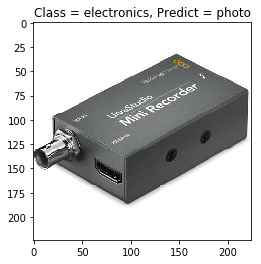

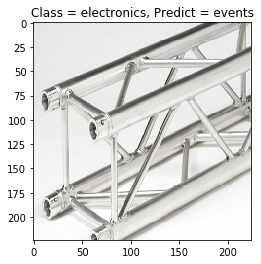

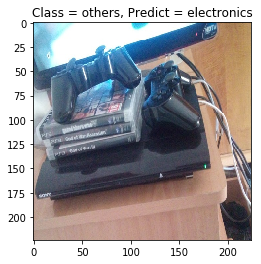

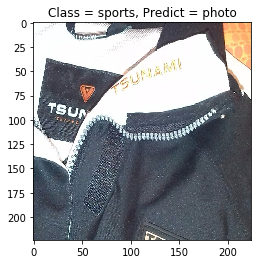

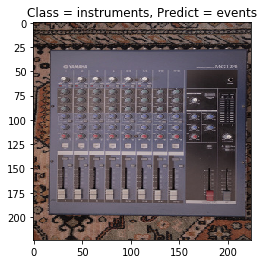

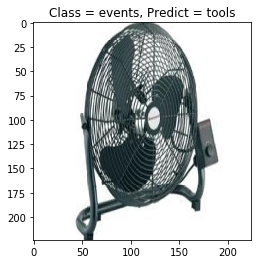

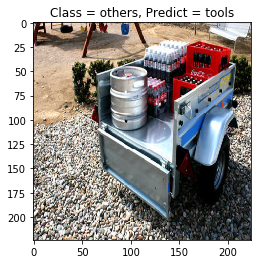

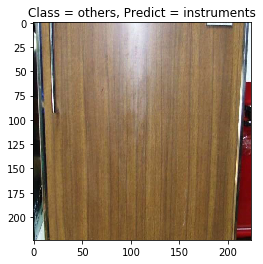

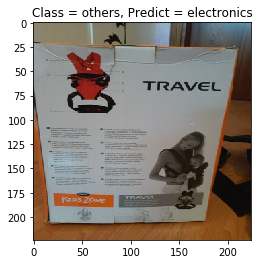

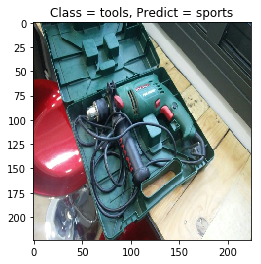

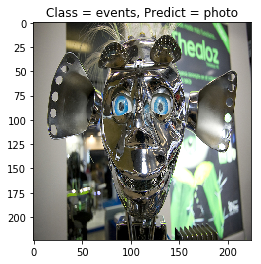

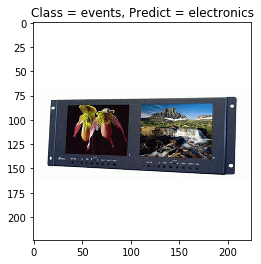

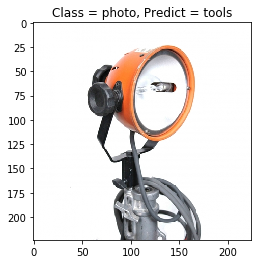

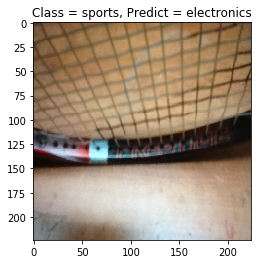

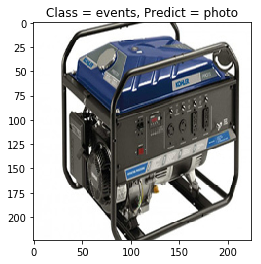

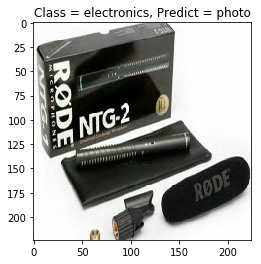

In [15]:
accuracy, y_pred, y_real = resnet_categorizer.evaluate(categories_test_data_dir, show_num_misclassified=10)

Accuracy obtained by ResNet50 in the test set: 73.97%


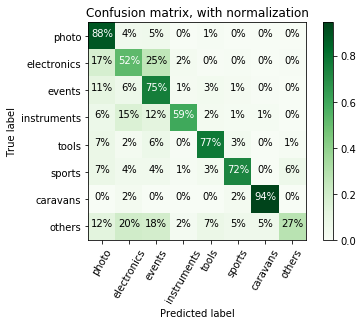

In [36]:
print "Accuracy obtained by ResNet50 in the test set: %.2f%%" % (accuracy*100)
cnf_matrix = confusion_matrix(y_real, y_pred)
plot_confusion_matrix(cnf_matrix, classes=CATEGORIES.values(), normalize=True,
                      title='Confusion matrix, with normalization')

The accuracy obtained by the model in the test set, almost **74%**, is exciting taking into account the toughness of the dataset, and the ambiguity inherent to some product. For example, considering the third missclassified example, should a videogame system be classified as "electronics" or as "others"? In that case, the user decided it belonged to "others" but the other categorization would be fine too.

Furthermore, from the confusion matrix and the misclassified samples it can be noted that, unsurprisingly, the category with the worst accuracy has been "others", where the items that don't belong to any of the other categories are supposed to be.

Finally, it also has to be noted that, even though "caravans" is the category with the lowest number of images, just 1.3% (258 out of 19393), it got the highest accuracy, showing that the Network is robust to unbalanced datasets.

## Part II: Subcategories

In [8]:
subcategories_train_data_dir = './subcategories-data/train'
subcategories_validation_data_dir = './subcategories-data/validation'
subcategories_test_data_dir = './subcategories-data/test'

#### Training setup

The training setup has been the same as in the categories section, with the following difference:

- `ReduceLROnPlateau` module from Keras has been used, which reduces the learning rate of the optimizer by a factor of 2 if a metric, in this case the validation accuracy, plateaus for 5 iterations.
- The last layer has been changed from a softmax to a sigmoid, which is more appropiate for multiclass output, i.e., when several classes might be correct at the same time. The number of hidden units has been updated accordingly to the number of subcategories.
- Two variants have been tried for fine tuning:
    1. ImageNet weights, as in the categories section.
    2. Post-category-training weights, using the best models obtained in the previous section.
- Finally, the number of epochs for the whole model has been reduced from 80 to 50.

Since ResNet50 was the model with the best performance in the previous setup, it was the chosen one to train for the subcategories problems.

#### ResNet50

In [ ]:
Categorizer(CATEGORIES). \
    build_model(ResNet50, weights='best_models/ResNet50.hdf5'). \
    change_top_model(SUBCATEGORIES, multiclass_output=True).compile_model(). \
    fine_tune(
        subcategories_train_data_dir,
        subcategories_validation_data_dir,
        batch_size=16,
        num_only_top_epochs=20,
        num_whole_model_epochs=50,
        best_model_path='best_models/ResNet50-subcats.hdf5',
        tensorboard_logs_path='tensorboard_logs/ResNet50-subcats'
    )

In [ ]:
Categorizer(SUBCATEGORIES). \
    build_model(ResNet50, weights='imagenet', multiclass_output=True). \
    compile_model(). \
    fine_tune(
        subcategories_train_data_dir,
        subcategories_validation_data_dir,
        batch_size=16,
        num_only_top_epochs=20,
        num_whole_model_epochs=50,
        best_model_path='best_models/ResNet50-subcats-imagenet.hdf5',
        tensorboard_logs_path='tensorboard_logs/ResNet50-subcats-imagenet'
    )

TensorBoard graph for the loss. The yellow graph represents the last part of the fine-tuning (whole model) for the case where the ImageNet weights were used as initialization. The blue graph represents the same, only using the weights of the best model from the categories problem as initialization.
<img style="margin: 20px" width="900px" src="images/resnet-subcats-loss.png">

In terms of validation accuracy, the result are the following, with the graphs colors being the same.
<img style="margin: 20px" width="900px" src="images/resnet-subcats-valacc.png">

In the light of the training results, it has to be noted how the Network initialized with the ImageNet weights outperforms the one with the best weights from the above training. This might be because the matching from ImageNet categories is closer to the ones in this subcategories dataset than to the categories one, therefore getting better performance out-of-the-box.

#### Testing

After the training, we evaluate our classifer by testing the top subcategory assigned to every test sample.

In [12]:
resnet_subcategorizer = Categorizer(SUBCATEGORIES). \
    build_model(ResNet50, weights='best_models/ResNet50-subcats-imagenet.hdf5'). \
    compile_model()

Found 858 images belonging to 13 classes.


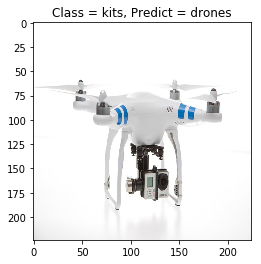

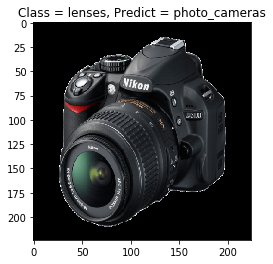

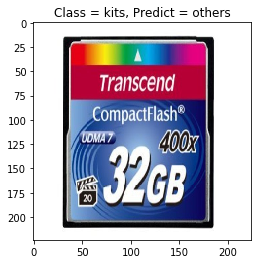

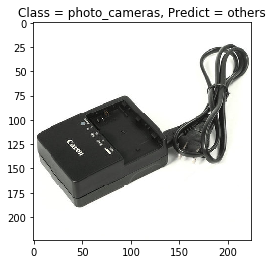

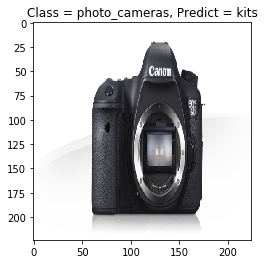

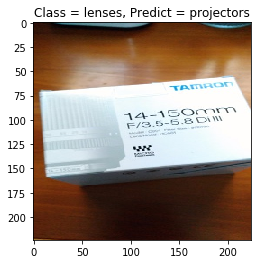

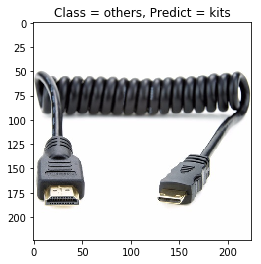

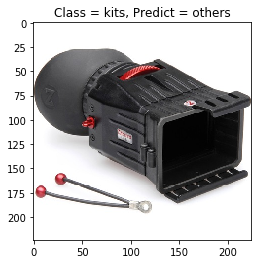

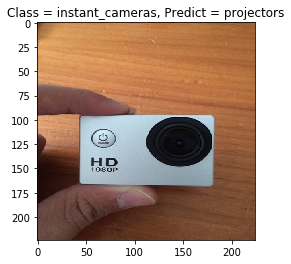

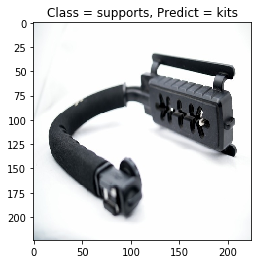

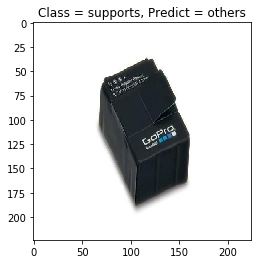

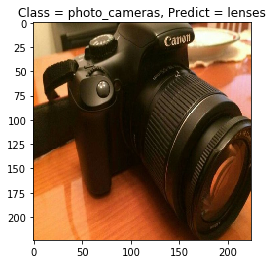

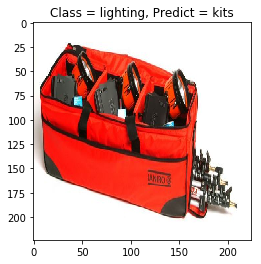

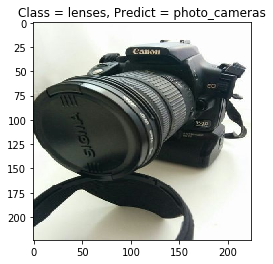

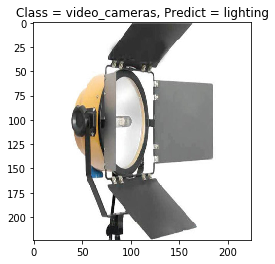

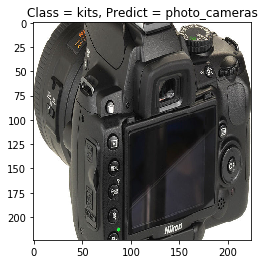

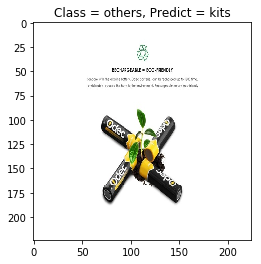

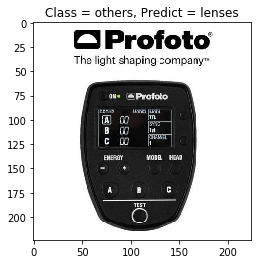

In [13]:
accuracy, y_pred, y_real = resnet_subcategorizer.evaluate(subcategories_test_data_dir, show_num_misclassified=10)

In [16]:
print "Accuracy obtained by ResNet50 picking the top subcategory in the test set: %.2f%%" % (accuracy*100)

Accuracy obtained by ResNet50 picking the top subcategory in the test set: 40.91%


The result obtained, almost **41%** is quite decent taking into account that only the top subcategory is being taken into account, and that the classes within a category are more similar to each other than those in different categories, so the Network has to be more precise in extracting the right features.

## Conclusions and future work

Convolutional Neural Networks have shown to be a really powerful tool to solve the categorization problem. This technology can be very beneficial to marketplace owners that don't have the ability or capacity to curate all the offer, yet they want to offer a great search experience where the users can find everything conveniently organized.

The fine-tuning approach has proved to be a great way to achieve production-ready accuracies without the need of training the networks with hundreds of thousands of samples during days. Hopefully, Neural Networks and Deep Learning researchers will continue to develop methods that will be useful not only for great corporations with the resources and the data, but also to the average user with a couple thousand samples.

Finally, there are plenty of ways to expand this work, being some of them, without any particular order, the following:
- The subcategories problem should be tried with the rest of architectures, and the testing part adapted to consider not only the top subcategory, but the top 3, for example, since this emulates more closely a real setup.
- A more rigurous research should be done in terms of time required to classify a sample with a cold start. In a real environment, the classifier would have to deal with single sample batches, and the time to produce an answer matters a lot. This could also be expanded even further by including a research of the resources consumption in terms of RAM, for example, for every architecture.
- Deploying the classifier to a production environment, where it can create real value, would probably be the most important future work that could be done.

## References

1. Erin Hogg, _"Lead Generation: How one additional form field decreased conversions 11% [Lead Gen Summit 2013 live test]."_ 2013. URL: https://www.marketingsherpa.com/article/case-study/how-one-additional-form-field 
2. Olga Russakovsky\*, Jia Deng\*, Hao Su, Jonathan Krause, Sanjeev Satheesh, Sean Ma, Zhiheng Huang, Andrej Karpathy, Aditya Khosla, Michael Bernstein, Alexander C. Berg and Li Fei-Fei. (* = equal contribution) _"ImageNet Large Scale Visual Recognition Challenge."_ IJCV, 2015.
3. François Chollet et al. _"Keras."_ 2015. URL: https://github.com/fchollet/keras
4. K. Simonyan, A. Zisserman. _"Very Deep Convolutional Networks for Large-Scale Image Recognition."_ 2014.
5. Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. _"Deep Residual Learning for Image Recognition."_ 2015.
6. Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich. _"Going Deeper with Convolutions."_ 2014.
7. François Chollet. _"Xception: Deep Learning with Depthwise Separable Convolutions."_ 2016.
8. John Duchi, Elad Hazan, Yoram Singer. _"Adaptive Subgradient Methods for Online Learning and Stochastic Optimization."_ 2011.



<img style="margin: auto" width="600px" src="images/columbia-university-logo.png">